In [42]:
import torch
from torch import nn
import numpy as np
from torch import distributions
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.nn.functional import pad
import copy

In [43]:
def antiderivTanh(x): # activation function aka the antiderivative of tanh
    return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x)))

def derivTanh(x): # act'' aka the second derivative of the activation function antiderivTanh
    return 1 - torch.pow( torch.tanh(x) , 2 )

class ResNN(nn.Module):
    def __init__(self, m, dx, dy=0, nTh=2):
        """
            ResNet N portion of Phi
        :param d:   int, dimension of space input (expect inputs to be d+1 for space-time)
        :param m:   int, hidden dimension
        :param nTh: int, number of resNet layers , (number of theta layers)
        """
        super().__init__()

        if nTh < 2:
            print("nTh must be an integer >= 2")
            exit(1)

        self.dx = dx
        self.dy = dy
        self.m = m
        self.nTh = nTh
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(dx + dy + 1, m, bias=True)) # opening layer
        self.layers.append(nn.Linear(m,m, bias=True)) # resnet layers
        for i in range(nTh-3):
            self.layers.append(copy.deepcopy(self.layers[1]))
        self.layers.append(nn.Linear(m,1, bias=True)) # resnet layers
        self.act = antiderivTanh
        self.h = 1.0 / (self.nTh-1) # step size for the ResNet

    def forward(self, x, y=None):
        """
            N(s;theta). the forward propogation of the ResNet
        :param x: tensor nex-by-d+1, inputs
        :return:  tensor nex-by-m,   outputs
        """
        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        xy = self.act(self.layers[0].forward(xy))

        for i in range(1,self.nTh):
            xy = xy + self.h * self.act(self.layers[i](xy))

        return xy



class Phi(nn.Module):
    def __init__(self, nTh, m, dx,dy=0, r=10, alph=[1.0] * 5):
        """
            neural network approximating Phi (see Eq. (9) in our paper)

            Phi( x,t ) = w'*ResNet( [x;t]) + 0.5*[x' t] * A'A * [x;t] + b'*[x;t] + c

        :param nTh:  int, number of resNet layers , (number of theta layers)
        :param m:    int, hidden dimension
        :param d:    int, dimension of space input (expect inputs to be d+1 for space-time)
        :param r:    int, rank r for the A matrix
        :param alph: list, alpha values / weighted multipliers for the optimization problem
        """
        super().__init__()

        self.m    = m
        self.nTh  = nTh
        self.dx = dx
        self.dy = dy
        self.alph = alph

        r = min(r,dx+dy+1) # if number of dimensions is smaller than default r, use that

 
        self.N = ResNN(m, dx,dy, nTh=nTh)

        # set initial values
  


    def forward(self, x, y=None):
        """ calculating Phi(s, theta)...not used in OT-Flow """
        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        return self.N(x,y)


    def trHess(self,x,y, justGrad=False ):
        """
        compute gradient of Phi wrt x and trace(Hessian of Phi); see Eq. (11) and Eq. (13), respectively
        recomputes the forward propogation portions of Phi

        :param x: input data, torch Tensor nex-by-d
        :param justGrad: boolean, if True only return gradient, if False return (grad, trHess)
        :return: gradient , trace(hessian)    OR    just gradient
        """

        # code in E = eye(d+1,d) as index slicing instead of matrix multiplication
        # assumes specific N.act as the antiderivative of tanh

        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        N    = self.N
        m    = N.layers[0].weight.shape[0]
        nex  = x.shape[0] # number of examples in the batch
        dx    = x.shape[1]-1

        u = [] # hold the u_0,u_1,...,u_M for the forward pass
        z = N.nTh*[None] # hold the z_0,z_1,...,z_M for the backward pass
        # preallocate z because we will store in the backward pass and we want the indices to match the paper

        # Forward of ResNet N and fill u
        opening     = N.layers[0].forward(xy) # K_0 * S + b_0
        u.append(N.act(opening)) # u0
        feat = u[0]

        for i in range(1,N.nTh):
            feat = feat + N.h * N.act(N.layers[i](feat))
            u.append(feat)

        # going to be used more than once
        tanhopen = torch.tanh(opening) # act'( K_0 * S + b_0 )

        # compute gradient and fill z
        for i in range(N.nTh-2,0,-1): # work backwards, placing z_i in appropriate spot
            if i == N.nTh-2:
                z[i+1] = N.layers[N.nTh-1].weight.t() # z_M = K_M^T

            term = z[i+1]
            # z_i = z_{i+1} + h K_i' diag(...) z_{i+1}
            z[i] = term + N.h * torch.mm( N.layers[i].weight.t() , torch.tanh( N.layers[i].forward(u[i-1]) ).t() * term)

        # z_0 = K_0' diag(...) z_1
        z[0] = torch.mm( N.layers[0].weight.t() , tanhopen.t() * z[1] )
        grad = z[0]

        if justGrad:
            return grad.t()

        # -----------------
        # trace of Hessian
        #-----------------

        # t_0, the trace of the opening layer
        Kopen = N.layers[0].weight[:,0:dx]    # indexed version of Kopen = torch.mm( N.layers[0].weight, E  )
        temp  = derivTanh(opening.t()) * z[1]
        trH  = torch.sum(temp.reshape(m, -1, nex) * torch.pow(Kopen.unsqueeze(2), 2), dim=(0, 1)) # trH = t_0

        # grad_s u_0 ^ T
        temp = tanhopen.t()   # act'( K_0 * S + b_0 )
        Jac  = Kopen.unsqueeze(2) * temp.unsqueeze(1) # K_0' * act'( K_0 * S + b_0 )
        # Jac is shape m by d by nex

        # t_i, trace of the resNet layers
        # KJ is the K_i^T * grad_s u_{i-1}^T
        for i in range(1,N.nTh - 1):
            KJ  = torch.mm(N.layers[i].weight , Jac.reshape(m,-1) )
            KJ  = KJ.reshape(m,-1,nex)
            term = z[i+1]

            temp = N.layers[i].forward(u[i-1]).t() # (K_i * u_{i-1} + b_i)
            t_i = torch.sum(  ( derivTanh(temp) * term ).reshape(m,-1,nex)  *  torch.pow(KJ,2) ,  dim=(0, 1) )
            trH  = trH + N.h * t_i  # add t_i to the accumulate trace
            Jac = Jac + N.h * torch.tanh(temp).reshape(m, -1, nex) * KJ # update Jacobian

        return grad.t(), trH 
        # indexed version of: return grad.t() ,  trH + torch.trace( torch.mm( E.t() , torch.mm(  symA , E) ) )


In [44]:

def vec(x):
    """vectorize torch tensor x"""
    return x.view(-1,1)


def OTFlowProblem(x, y, Phi, tspan, nt, stepper="rk4", alph=[1.0, 1.0, 1.0]):
    """

    Evaluate objective function of OT Flow problem; see Eq. (8) in the paper.

    :param x:       input data tensor nex-by-dx
    :param y:       input data tensor nex-by-dy
    :param Phi:     neural network
    :param tspan:   time range to integrate over, ex. [0.0 , 1.0]
    :param nt:      number of time steps
    :param stepper: string "rk1" or "rk4" Runge-Kutta schemes
    :param alph:    list of length 3, the alpha value multipliers
    :return:
        Jc - float, objective function value dot(alph,cs)
        cs - list length 5, the five computed costs
    """
    h = (tspan[1]-tspan[0]) / nt

    # initialize "hidden" vector to propogate with all the additional dimensions for all the ODEs
    z = pad(x, (0, 3, 0, 0), value=0)

    tk = tspan[0]

    if stepper=='rk4':
        for k in range(nt):
            z = stepRK4(odefun, z, y, Phi, alph, tk, tk + h)
            tk += h
    elif stepper=='rk1':
        for k in range(nt):
            z = stepRK1(odefun, z, y, Phi, alph, tk, tk + h)
            tk += h

    # ASSUME all examples are equally weighted
    costL  = torch.mean(z[:,-2])
    costC  = torch.mean(C(z))
    costR  = torch.mean(z[:,-1])

    cs = [costL, costC, costR]

    # return dot(cs, alph)  , cs
    return sum(i[0] * i[1] for i in zip(cs, alph)) , cs


def stepRK4(odefun, z, y, Phi, alph, t0, t1):
    """
        Runge-Kutta 4 integration scheme
    :param odefun: function to apply at every time step
    :param z:      tensor nex-by-d+4, inputs
    :param Phi:    Module, the Phi potential function
    :param alph:   list, the 3 alpha values for the OT-Flow Problem
    :param t0:     float, starting time
    :param t1:     float, end time
    :return: tensor nex-by-d+4, features at time t1
    """

    h = t1 - t0 # step size
    z0 = z

    K = h * odefun(z0, y, t0, Phi, alph=alph)
    z = z0 + (1.0/6.0) * K

    K = h * odefun(z0 + 0.5 * K, y, t0 + (h / 2), Phi, alph=alph)
    z += (2.0/6.0) * K

    K = h * odefun(z0 + 0.5 * K, y, t0 + (h / 2), Phi, alph=alph)
    z += (2.0/6.0) * K

    K = h * odefun(z0 + K, y, t0 + h, Phi, alph=alph)
    z += (1.0/6.0) * K

    return z


def stepRK1(odefun, z, y, Phi, alph, t0, t1):
    """
        Runge-Kutta 1 / Forward Euler integration scheme.  Added for comparison, but we recommend stepRK4.
    :param odefun: function to apply at every time step
    :param z:      tensor nex-by-d+4, inputs
    :param Phi:    Module, the Phi potential function
    :param alph:   list, the 3 alpha values for the mean field game problem
    :param t0:     float, starting time
    :param t1:     float, end time
    :return: tensor nex-by-d+4, features at time t1
    """
    z += (t1 - t0) * odefun(z, y, t0, Phi, alph=alph)
    return z


def integrate(x, y, net, tspan, nt, stepper="rk4", alph=[1.0, 1.0, 1.0], intermediates=False):
    """
        perform the time integration in the d-dimensional space
    :param x:       input data tensor nex-by-dx
    :param y:       input data tensor nex-by-dy
    :param net:     neural network Phi
    :param tspan:   time range to integrate over, ex. [0.0 , 1.0]
    :param nt:      number of time steps
    :param stepper: string "rk1" or "rk4" Runge-Kutta schemes
    :param alph:    list of length 3, the alpha value multipliers
    :param intermediates: bool, True means save all intermediate time points along trajectories
    :return:
        z - tensor nex-by-d+4, features at time t1
        OR zFull - tensor nex-by-d+3-by-nt+1 , trajectories from time t0 to t1 (when intermediates=True)
    """

    h = (tspan[1]-tspan[0]) / nt

    # initialize "hidden" vector to propagate with all the additional dimensions for all the ODEs
    z = pad(x, (0, 3, 0, 0), value=tspan[0])

    tk = tspan[0]

    if intermediates: # save the intermediate values as well
        zFull = torch.zeros(*z.shape, nt + 1, device=x.device,
                            dtype=x.dtype)  # make tensor of size z.shape[0], z.shape[1], nt
        zFull[:,:,0] = z

        if stepper == 'rk4':
            for k in range(nt):
                zFull[:, :, k + 1] = stepRK4(odefun, zFull[:, :, k], y, net, alph, tk, tk + h)
                tk += h
        elif stepper == 'rk1':
            for k in range(nt):
                zFull[:, :, k + 1] = stepRK1(odefun, zFull[:, :, k], y, net, alph, tk, tk + h)
                tk += h

        return zFull

    else:
        if stepper == 'rk4':
            for k in range(nt):
                z = stepRK4(odefun, z, y, net, alph, tk, tk + h)
                tk += h
        elif stepper == 'rk1':
            for k in range(nt):
                z = stepRK1(odefun, z, y, net, alph, tk, tk + h)
                tk += h

        return z

    # return in case of error
    return -1



def C(z):
    """Expected negative log-likelihood; see Eq.(3) in the paper"""
    d = z.shape[1]-3
    l = z[:,d] # log-det

    return -( torch.sum(  -0.5 * torch.log(torch.tensor(2.0)*torch.pi) - torch.pow(z[:,0:d],2) / 2  , 1 , keepdims=True ) + l.unsqueeze(1) )


def odefun(x, y, t, net, alph=[1.0, 1.0, 1.0]):
    """
    neural ODE combining the characteristics and log-determinant (see Eq. (2)), the transport costs (see Eq. (5)), and
    the HJB regularizer (see Eq. (7)).

    d_t  [x ; l ; v ; r] = odefun( [x ; l ; v ; r] , t )

    x - particle position
    l - log determinant
    v - accumulated transport costs (Lagrangian)
    r - accumulates violation of HJB condition along trajectory
    """
    nex, d_extra = x.shape
    d = d_extra - 3

    z = pad(x[:, :d], (0, 1, 0, 0), value=t) # concatenate with the time t

    gradPhi, trH = net.trHess(z, y)

    dx = -(1.0) * gradPhi[:,0:d]
    dl = -(1.0) * trH.unsqueeze(1)
    dv = 0.5 * torch.sum(torch.pow(dx, 2) , 1 ,keepdims=True)
    dr = torch.abs(-gradPhi[:, d].unsqueeze(1) + alph[0] * dv)

    return torch.cat( (dx,dl,dv,dr) , 1  )

In [45]:
alpha = 1 #np.random.uniform(0.5, 1.5)
beta = 0.1
gamma = 0.1
delta = 0.02
dt = 0.01


In [46]:
def lotka_volterra(x, y, alpha, beta, gamma, delta, dt):
    dx = (alpha * x - beta * x * y) * dt
    dy = (-gamma * y + delta * x * y) * dt
    return x + dx, y + dy


def simulate_lotka_volterra(alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps):
    x, y = x0, y0
    dt = torch.tensor([dt] * len(steps))
    for i in range(max_steps):
        dt = torch.where(steps > i, dt, 0)
        x, y = lotka_volterra(x, y, alpha, beta, gamma, delta, dt)

    return x, y

In [47]:
def data_generator(num_samples):

    max_steps = 10
    steps = torch.tensor(np.random.randint(1, max_steps, num_samples))

    x0 = torch.tensor(np.random.randint(1, 40, num_samples))
    y0 = torch.tensor(np.random.randint(1, 40, num_samples))
    alpha = torch.tensor(np.random.uniform(0.5, 1.5, num_samples))
    gamma = torch.tensor(np.random.uniform(0.01, 0.5, num_samples))
    beta = torch.tensor(np.random.uniform(0.01, 0.5, num_samples))
    delta = torch.tensor(np.random.uniform(0.01, 0.05, num_samples))

    x, y = simulate_lotka_volterra(
        alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps
    )
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    steps = steps.unsqueeze(1)
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    alpha = alpha.unsqueeze(1)
    gamma = gamma.unsqueeze(1)
    beta = beta.unsqueeze(1)
    delta = delta.unsqueeze(1)
    obs = torch.cat([x, y], dim=1)
    state = torch.cat([x0, y0, steps, alpha, beta, gamma, delta], dim=1)

    return state, obs

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
nTh = 3# number of layers
width = 64 # width of network
alph = [1,20,5] # alph[0]-> weight for transport costs, alph[1] and alph[2]-> HJB penalties
dimx = 7
dimy = 2

net = Phi(nTh=nTh, m=width, dx=dimx, dy=dimy, alph=alph)

prior = distributions.MultivariateNormal(torch.zeros(dimx).to(device), torch.eye(dimx).to(device))
nt = 2
x, y = data_generator(1000)
batch_size = 1000
test_x, test_y = data_generator(100)



In [50]:
batch_size = 5000
num_steps = 10000

optim = torch.optim.Adam(net.parameters(), lr=0.01) # lr=0.04 good
loss_arr = []
test_loss_arr = []

dataloader = torch.utils.data.DataLoader(list(zip(x,y)), batch_size=batch_size, shuffle=True)
sheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=500, gamma=0.5)
for step in range(num_steps):
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        Jc, cs = OTFlowProblem(x_batch, y_batch, net, [0.0, 1.0], nt, alph=alph)
        optim.zero_grad()
        Jc.backward()
        optim.step()
        loss_arr.append(Jc.item())
    sheduler.step()
    if step % 50 == 0:
        print(f"Step {step}, Jc: {Jc}, cs: {cs}")
    if step % 100 == 0:
        test_JC, test_cs = OTFlowProblem(test_x.to(device).float(), test_y.to(device).float(), net, [0.0, 1.0], nt, alph=alph)
        test_loss_arr.append(test_JC.item())
        print(f"Test JC: {test_JC}, cs: {test_cs}")


Step 0, Jc: 10901.953125, cs: [tensor(0.0507, grad_fn=<MeanBackward0>), tensor(545.0736, grad_fn=<MeanBackward0>), tensor(0.0860, grad_fn=<MeanBackward0>)]
Test JC: 9663.537109375, cs: [tensor(0.1681, grad_fn=<MeanBackward0>), tensor(483.1197, grad_fn=<MeanBackward0>), tensor(0.1952, grad_fn=<MeanBackward0>)]
Step 50, Jc: 2843.46923828125, cs: [tensor(346.4675, grad_fn=<MeanBackward0>), tensor(47.1749, grad_fn=<MeanBackward0>), tensor(310.7009, grad_fn=<MeanBackward0>)]
Step 100, Jc: 2367.10400390625, cs: [tensor(327.3484, grad_fn=<MeanBackward0>), tensor(48.1122, grad_fn=<MeanBackward0>), tensor(215.5022, grad_fn=<MeanBackward0>)]
Test JC: 2148.51318359375, cs: [tensor(308.2404, grad_fn=<MeanBackward0>), tensor(42.4677, grad_fn=<MeanBackward0>), tensor(198.1838, grad_fn=<MeanBackward0>)]
Step 150, Jc: 1381.9229736328125, cs: [tensor(424.4377, grad_fn=<MeanBackward0>), tensor(35.9255, grad_fn=<MeanBackward0>), tensor(47.7951, grad_fn=<MeanBackward0>)]
Step 200, Jc: 1172.8253173828125, 

KeyboardInterrupt: 

Text(0, 0.5, 'Negative Log Likelihood')

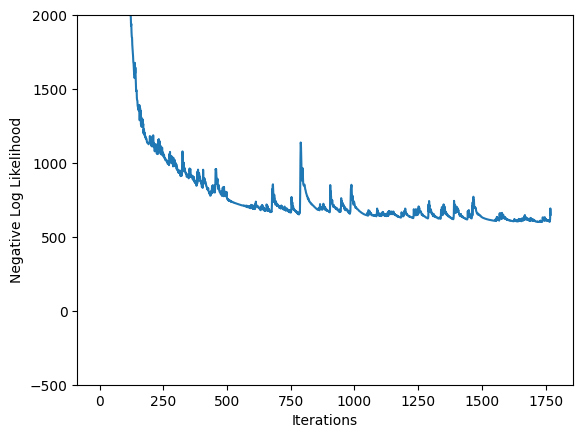

In [51]:
plt.plot(loss_arr)
plt.ylim(-500, 2000)
plt.xlabel("Iterations")
plt.ylabel("Negative Log Likelihood")

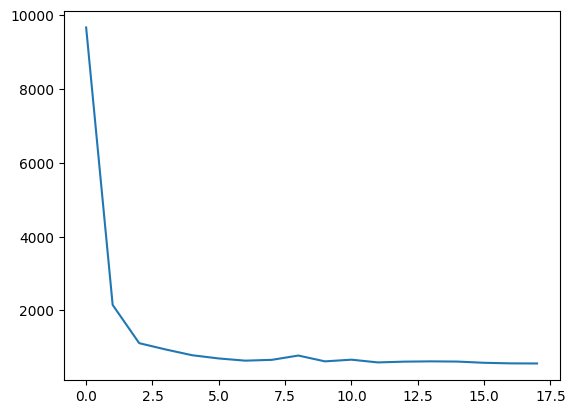

In [52]:
plt.plot(test_loss_arr)


In [53]:
col_green = '1b9e77'
col_orange = 'd95f02'
col_purple = '7570b3'

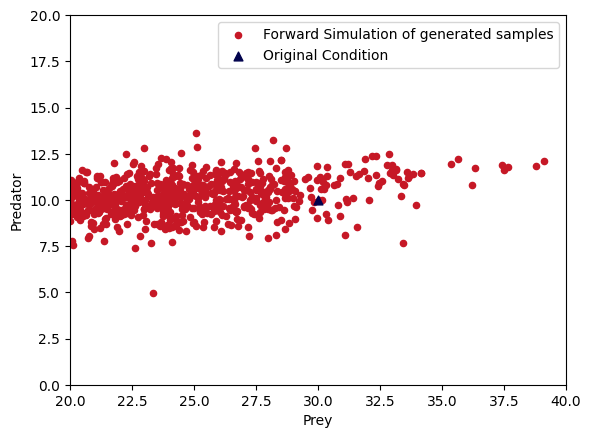

In [128]:
x_ = 30
y_ = 10
z = prior.sample((1000,)).to(device)
cond = torch.tensor([[x_, y_]]).repeat(1000, 1).to(device)
finvx = integrate(z, cond, net, [1.0, 0.0], 32, stepper="rk4", alph=net.alph)
modelGen = finvx.detach().cpu()
max_steps = 10

angles = modelGen
result_x, result_y = simulate_lotka_volterra(
        angles[:, 3],
        angles[:, 4],
        angles[:, 5],
        angles[:, 6],
        angles[:, 0],
        angles[:, 1],
        angles[:, 2],
        dt,
        max_steps,
        )
target = [x_, y_]
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'
plt.scatter(result_x, result_y, s = 20, c = col_red, alpha = 1, label='Forward Simulation of generated samples')
plt.scatter(target[0], target[1], marker = '^',s = 40, alpha = 1, c=col_blue, label='Original Condition')
plt.xlim(target[0]-10, target[0]+10)
plt.ylim(target[1]-10, target[1]+10)
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()
        
        

In [129]:
print(np.mean(result_x.detach().numpy()), np.mean(result_y.detach().numpy()))

22.5894 10.194629


In [130]:
print(np.mean(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

7.971377


In [131]:
concatenated_array = torch.stack([result_x, result_y])
print(torch.cov(concatenated_array))

tensor([[26.5882,  1.2287],
        [ 1.2287,  1.0697]])


In [132]:
print(np.max(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

24.272303


In [133]:
print(np.min(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

0.04159693


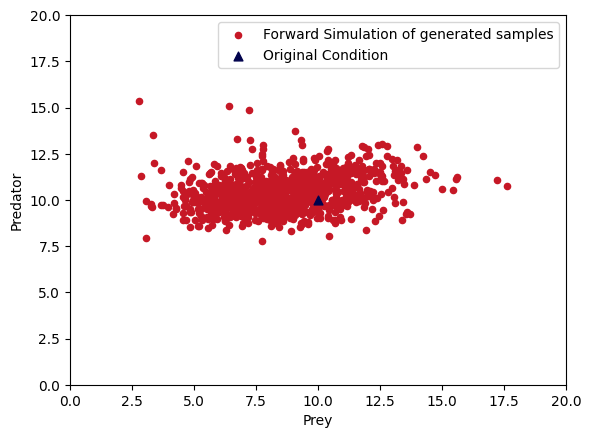

In [134]:
x_ = 10
y_ = 10
z = prior.sample((1000,)).to(device)
cond = torch.tensor([[x_, y_]]).repeat(1000, 1).to(device)
finvx = integrate(z, cond, net, [1.0, 0.0], 32, stepper="rk4", alph=net.alph)
modelGen = finvx.detach().cpu()
max_steps = 10

angles = modelGen
result_x, result_y = simulate_lotka_volterra(
        angles[:, 3],
        angles[:, 4],
        angles[:, 5],
        angles[:, 6],
        angles[:, 0],
        angles[:, 1],
        angles[:, 2],
        dt,
        max_steps,
        )
target = [x_, y_]
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'
plt.scatter(result_x, result_y, s = 20, c = col_red, alpha = 1, label='Forward Simulation of generated samples')
plt.scatter(target[0], target[1], marker = '^',s = 40, alpha = 1, c=col_blue, label='Original Condition')
plt.xlim(target[0]-10, target[0]+10)
plt.ylim(target[1]-10, target[1]+10)
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()
        

In [135]:
def MMD(x, y):
        gamma = 2
        xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2. * xx # Used for A in (1)
        dyy = ry.t() + ry - 2. * yy # Used for B in (1)
        rxx = rx[0].repeat(y.shape[0], 1)
        ryy = ry[0].repeat(x.shape[0], 1) 
        dxy = rxx.t() + ryy - 2. * zz # Used for C in (1)

        XX, YY, XY = (torch.zeros(xx.shape).to(device),
                      torch.zeros(yy.shape).to(device),
                      torch.zeros(zz.shape).to(device))
        XX += 1/(1 + dxx/gamma**2)
        YY += 1/(1 + dyy/gamma**2)
        XY += 1/(1 + dxy/gamma**2)
        return XX.mean() + YY.mean() - 2*XY.mean()

In [136]:
print(MMD(x.float(), angles.float()))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x7 and 10x1000)